# Getting started

This notebook contains code samples to show the usage of the data and MIPHA implementations contained in this repository.

## Installing requirements

Refer to README.md for a guide on how to install the required dependencies to run this notebook.

## Datasets

### Unzipping data
The data was zipped for sharing over git, as the unzipped files are bigger than the recommended size. In total, the provided datasets should take under 150MB disk space.
Execute the following cells to unpack the data from `g1g2_samples.zip` into the `data/` directory.

In [21]:
import zipfile
import os

def unzip_file(zip_path, extract_to):
    """Unzips a file to the specified directory."""
    os.makedirs(extract_to, exist_ok=True)  # Ensure the output directory exists
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Data extracted to {extract_to}.")

In [22]:
unzip_file("data/g1g2_samples.zip", "data")

Data extracted to data.


### Opening data
Each matrix is stored as a pickle file. All the given data sources correspond to 3D data of shape `(n_samples, n_timesteps, n_features)`.
- `n_samples`: number of records in the data source.
- `n_timesteps`: number of rows in each matrix (e.g. each row corresponds to one month).
- `n_features`: number of columns in each matrix (e.g. each column corresponds to the results of one analysis over `n_timesteps` months).


In [23]:
from pathlib import Path
import pickle


def save_pickle(dataframes, filename):
    """
    :param dataframes: provided as a dictionary where keys are patient IDs
    :param filename: file to save to
    """
    print(f"Saving data to {filename}...")
    with open(filename, "wb") as handle:
        pickle.dump(dataframes, handle)
    print(f"Data successfully saved to {filename}")


def save_to_file(obj, filepath):
    """
    Save object to file. If the given parent directory doesn't exist, create it.
    :param obj: The object to save.
    :param filepath: The path to save to.
    """
    parent_dir = Path(filepath).parent  # Extract the parent directory
    parent_dir.mkdir(parents=True, exist_ok=True)  # Create the parent directory if it doesn't exist
    save_pickle(obj, filepath)


def load_pickle(filename):
    """
    :param filename: file to load data from
    """
    print(f"Loading data from {filename}...")
    with open(filename, "rb") as file:
        result = pickle.load(file)
        print(f"Data successfully loaded from {filename}")
        return result

In [24]:
matrix_path = f"data/g1g2_samples/most_common_dataset/most_common_analyses.pkl"
matrix = load_pickle(matrix_path)
print(matrix.shape)

Loading data from data/g1g2_samples/most_common_dataset/most_common_analyses.pkl...
Data successfully loaded from data/g1g2_samples/most_common_dataset/most_common_analyses.pkl
(12250, 12, 27)


In [25]:
matrix[0]

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  96.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  96.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  96.        ,   0.        ,   0.        ,
  

In [26]:
labels_path = f"data/g1g2_samples/most_common_dataset/labels.pkl"
labels = load_pickle(labels_path)
print(labels.shape)

Loading data from data/g1g2_samples/most_common_dataset/labels.pkl...
Data successfully loaded from data/g1g2_samples/most_common_dataset/labels.pkl
(12250,)


## MIPHA implementation
### Building the model

In the following cell, we build a MIPHA model using components provided in `implementations/components/`

In [43]:
from implementations.components.feature_extractors.pass_through_feature_extractor import PassThroughFeatureExtractor
from implementations.components.evaluators.classification_evaluator import ClassificationEvaluator
from sklearn.preprocessing import StandardScaler
from implementations.components.kernels.simple_data_processing_kernel import SimpleDataProcessingKernel
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from implementations.components.aggregators.horizontal_stack_aggregator import HorizontalStackAggregator

RANDOM_SEED = 42  # ensures some random operations are reproducible


def setup_components(n_timesteps, n_features):
    """
    Returns all components of the MIPHA model in a dictionary.
    This example function creates a model with:
    - Pass through feature extractors (no feature extraction)
    - Horizontal stack aggregator (simple stacking of features)
    - Random forest Kernel (machine learning model)
    - Classification Evaluator (returns common evaluation metrics)

    To create another MIPHA model, one can change the way components are set up below.
    """
    print("Setting up MIPHA components...")
    model_input_shape = (n_timesteps, n_features)

    print(f"Computed model input shape: {model_input_shape}")

    # Feature extractors
    feature_extractors = [
        PassThroughFeatureExtractor(
            component_name="lab_extractor",
            managed_data_types=["laboratory"],
        ),
        PassThroughFeatureExtractor(
            component_name="demographics_extractor",
            managed_data_types=["demographics"],
        )
    ]

    # Aggregator
    # ⚠️ only set always_flatten to True if the Kernel requires 2D data!
    # This is the case here with RandomForestClassifier, it would be different with certain neural networks
    aggregator = HorizontalStackAggregator(always_flatten=True)

    # Kernel
    kernel = SimpleDataProcessingKernel(
        model=RandomForestClassifier,
        n_estimators=100,  # Number of trees in the forest
        max_depth=10,  # Maximum tree depth
        min_samples_split=5,  # Minimum number of samples required to split a node
        min_samples_leaf=5,  # Minimum number of samples required to be at a leaf node
        max_features='sqrt',  # Use the square root of the number of features
        bootstrap=True,  # Use bootstrap sampling
        class_weight='balanced',
        verbose=1,
        random_state=RANDOM_SEED,
        component_name=None,  # default params
        imputer=None,  # imputation is already done when data sources are loaded
        resampler=RandomOverSampler(random_state=RANDOM_SEED, sampling_strategy=0.5),
        scaler=StandardScaler(),
    )

    # Evaluator
    evaluator = ClassificationEvaluator()

    return {
        "feature_extractors": feature_extractors,
        "aggregator": aggregator,
        "model": kernel,
        "evaluator": evaluator,
    }

In the next cell, we define a utility function to run a MIPHA model based on the previous setup.

In [44]:
from datetime import datetime
from mipha.framework import MiphaPredictor


def run_mipha(
        setup_components_func,
        data_sources_train,
        data_sources_test,
        labels_train,
        labels_test,
        fit_parameters,
        threshold=0.5,
        save_results=None,
        save_model=None,
        save_y=None,
        experiment_name=None,
):
    """
    Train, test and evaluate the MIPHA model using the given configuration on the given data sources. Model, results and outputs can be saved if optional parameters are saved.
    :param setup_components_func: function called to set up MIPHA components
    :param data_sources_train: data sources used for training
    :param data_sources_test: data sources used for testing
    :param labels_train: labels used for training
    :param labels_test: labels used for testing
    :param fit_parameters: parameters to pass to the fit function
    :param threshold: threshold used to evaluate predictions
    :param save_results: file to save the results to
    :param save_model: file to save the trained MIPHA model to
    :param save_y: path to save y_pred, y_pred_classes and labels_test to
    :param experiment_name: prefix used to name files generated if save_y is set
    :return:
    """

    # Retrieving data shape
    first_matrix = data_sources_train[0].data
    n_timesteps, n_features = first_matrix.shape[1], first_matrix.shape[2]

    # Setting up the model
    components = setup_components_func(n_timesteps, n_features)
    mipha = MiphaPredictor(
        feature_extractors=components['feature_extractors'],
        aggregator=components['aggregator'],
        model=components['model'],
        evaluator=components['evaluator'],
    )

    # Fitting the model
    mipha.fit(
        data_sources=data_sources_train,
        train_labels=labels_train,
        **fit_parameters,
    )

    if save_model:
        mipha.save(save_model)

    # Using the evaluator to collect results
    mipha.evaluate(
        data_sources=data_sources_test,
        test_labels=labels_test,
        threshold=threshold,
    )

    # Saving artifacts
    if save_results:
        mipha.evaluator.save_metrics_to_json(save_results)
    mipha.evaluator.display_results()

    if save_y:
        y_pred = mipha.evaluator.y_pred
        y_pred_classes = mipha.evaluator.y_pred_classes

        save_to_file(y_pred, os.path.join(save_y, experiment_name + "_y_pred.pkl"))
        save_to_file(y_pred_classes, os.path.join(save_y, experiment_name + "_y_pred_classes.pkl"))
        save_to_file(labels_test, os.path.join(save_y, experiment_name + "_y_test.pkl"))

    print(f"Computation finished at {datetime.now()}")

## Running the implementation

### Creating data sources

In order to run the implementation, data needs to be formatted as data sources. This is a simple process, but it is necessary.
Besides, we will split the data into a training and test sets.

In [45]:
from sklearn.model_selection import train_test_split

# Train-test split, keep 20% for test
x_train, x_test, y_train, y_test = train_test_split(
    matrix, labels, test_size=0.2, random_state=RANDOM_SEED
)

In [46]:
from mipha.framework import DataSource

data_source_train = DataSource(
    data=x_train,
    data_type="laboratory",  # make sure this corresponds to the types handled by feature extractors
    name="most_common_analyses_data_source_train",
)

data_source_test = DataSource(
    data=x_test,
    data_type="laboratory",
    name="most_common_analyses_data_source_test",
)

Setting up MIPHA components...
Computed model input shape: (12, 27)
Fitting the model...
Extracting features from data sources...
Feature extraction complete!
The last feature extraction can be accessed by using MiphaPredictor.last_computed_features.

Aggregating features from data sources...
Aggregation complete!

[SimpleDataProcessingKernel_6e3991f8-08e9-4b0c-a600-d00d0838bcd5] Processing train data... (shapes: x (9800, 324), y (9800,))

[SimpleDataProcessingKernel_6e3991f8-08e9-4b0c-a600-d00d0838bcd5] Train data processed (shapes: x (13788, 324), y (13788,))


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s


Model fit successfully!

Extracting features from data sources...
Feature extraction complete!
The last feature extraction can be accessed by using MiphaPredictor.last_computed_features.

Aggregating features from data sources...
Aggregation complete!

[SimpleDataProcessingKernel_6e3991f8-08e9-4b0c-a600-d00d0838bcd5] Processing test data... (shape: x (2450, 324))
[SimpleDataProcessingKernel_6e3991f8-08e9-4b0c-a600-d00d0838bcd5]Test data processed (shape: x (2450, 324))
CLASSIFICATION REPORT  ---------
              precision    recall  f1-score      support
0              0.992301  0.958443  0.975078  2286.000000
1              0.607438  0.896341  0.724138   164.000000
accuracy       0.954286  0.954286  0.954286     0.954286
macro avg      0.799869  0.927392  0.849608  2450.000000
weighted avg   0.966538  0.954286  0.958280  2450.000000

CONFUSION MATRIX  --------------


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


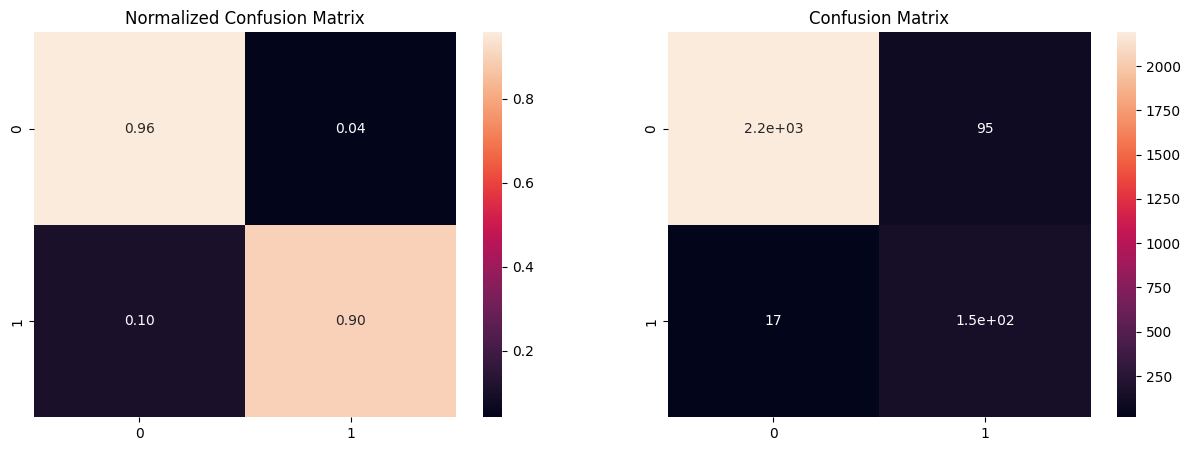


PRECISION-RECALL CURVE ---------


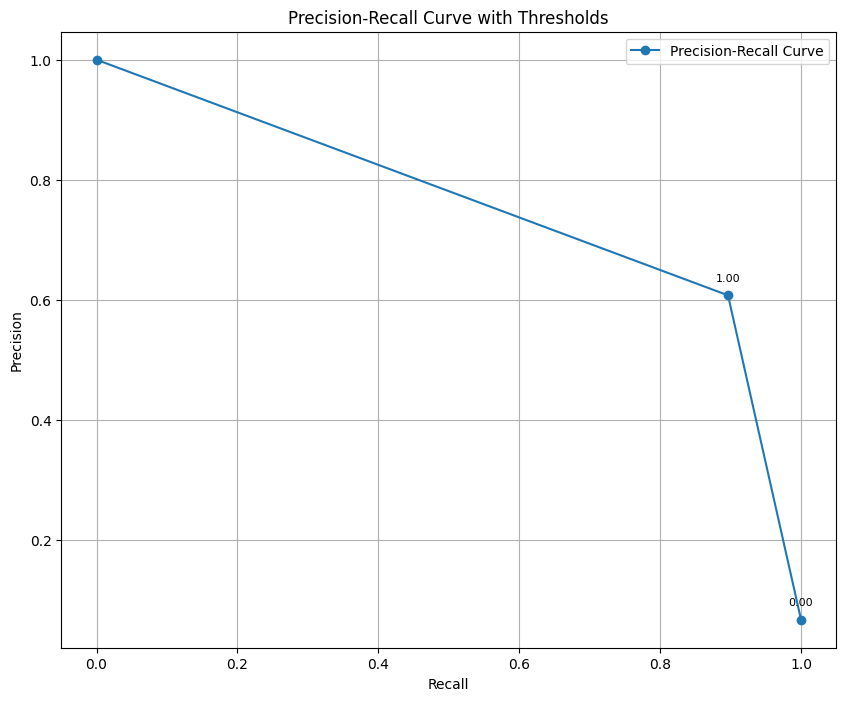

Computation finished at 2025-03-18 15:55:54.906884


In [47]:
results_save_path = f"out/results/example_implementation.json"

run_mipha(
    setup_components_func=setup_components,
    data_sources_train=[data_source_train], # given as a list because there can be several
    data_sources_test= [data_source_test],
    labels_train=y_train,
    labels_test=y_test,
    fit_parameters={}, # fed into the kernel, none in this case
    threshold=0.5,
    save_results=None,
)